### Group 4: Austin Hoeft, Gleb Borovoy

In [245]:
from __future__ import print_function

In [658]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 300)

In [128]:
# Data Cleaning #

# Drop all policy code 2 rows - not publically available
# drop rows with all NAN
# drop rows with descriptions about data (rows that are breaking up the data)

# do we want to leave in rows that have teh "Does not meet credit policy" marker? - check here: http://alexmwai.com/project/2016/07/19/loan1.html
                                                                                #   and here: https://forum.lendacademy.com/?topic=2427.msg20813#msg20813
# ^ We might want to remove it. It indicates that it no longer meets the credit policy so we don't want to train our model
#   and lend based on data that no longer meets the lending policy

# do we want more than just 1 and 0 in laon status? feels like we lose something but we are just trying to distinguish
# default/chargeoff vs not

### 1. Data importation and configuration

In [129]:
# Import dataset A

lc_data_a = pd.read_csv('LoanStats3a_securev1.csv', header = 1, parse_dates = True)
#print(lc_data_a.info())
print(len(lc_data_a))

# drop the last two rows of the dataframe that contain non-useful rows
lc_data_a.drop(lc_data_a.tail(2).index,inplace=True)

# drop row that separates data in the middle that contains the below string
lc_data_a = lc_data_a[~lc_data_a['id'].isin(['Loans that do not meet the credit policy'])]

#dropping does not meet credit policy data (see justification above)
lc_data_a = lc_data_a[~lc_data_a['loan_status'].isin(['Does not meet the credit policy. Status:Fully Paid'])]
lc_data_a = lc_data_a[~lc_data_a['loan_status'].isin(['Does not meet the credit policy. Status:Charged Off'])]

# checking total number of rows that were deleted
#print(lc_data_a.info())
print(len(lc_data_a))

#lc_data_a.head(5)
#lc_data_a.tail(5)

42538
39786


In [130]:
# Import dataset B

lc_data_b= pd.read_csv('LoanStats3b_securev1.csv', header = 1, parse_dates = True)
#print(lc_data_b.info())
print(len(lc_data_b))

# drop the last two rows of the dataframe that contain non-useful rows
lc_data_b.drop(lc_data_b.tail(2).index,inplace=True)

# drop row that separates data in the middle that contains the below string
lc_data_b = lc_data_b[~lc_data_b['id'].isin(['Loans that do not meet the credit policy'])]

# checking total number of rows that were deleted
#print(lc_data_b.info())
print(len(lc_data_b))

#lc_data_b.head()
#lc_data_b.tail()

188125
188123


In [131]:
# Import dataset C

lc_data_c = pd.read_csv('LoanStats3c_securev1.csv', header = 1, parse_dates = True)
#print(lc_data_c.info())
print(len(lc_data_c))

# drop the last two rows of the dataframe that contain non-useful rows
lc_data_c.drop(lc_data_c.tail(2).index,inplace=True)

# drop row that separates data in the middle that contains the below string
lc_data_c = lc_data_c[~lc_data_c['id'].isin(['Loans that do not meet the credit policy'])]

# checking total number of rows that were deleted
#print(lc_data_c.info())
print(len(lc_data_c))

#lc_data_c.head()
#lc_data_c.tail()

235631
235629


In [132]:
# Import dataset D

lc_data_d = pd.read_csv('LoanStats3d_securev1.csv', header = 1, parse_dates = True)
#print(lc_data_d.info())
print(len(lc_data_d))

# drop the last two rows of the dataframe that contain non-useful rows
lc_data_d.drop(lc_data_d.tail(2).index,inplace=True)

# drop row that separates data in the middle that contains the below string
lc_data_d = lc_data_d[~lc_data_d['id'].isin(['Loans that do not meet the credit policy'])]

# checking total number of rows that were deleted
#print(lc_data_d.info())
print(len(lc_data_d))

#lc_data_d.head()
#lc_data_d.tail()

421097
421095


In [654]:
# Combining all data

lc_data = pd.concat([lc_data_a, lc_data_b, lc_data_c, lc_data_d], ignore_index = True)

In [ ]:
lc_data.info()

In [356]:
# dropping columns due to Nan values, variables that are not inpluded in the dictionary, and 'future' variables
    
drop_no_use = ['emp_title', 'earliest_cr_line', 'next_pymnt_d', 'url', 'desc', 'zip_code',
             'title', 'issue_d', 'member_id', ]

for i in drop_no_use:
    lc_data.drop(i, axis=1, inplace=True)
    
    
# Dropping columns because of missing values
drop_missing = ['open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 
             'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
            'annual_inc_joint', 'dti_joint', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 
            'mo_sin_old_il_acct', 'verification_status_joint']

for i in drop_missing:
    lc_data.drop(i, axis=1, inplace=True)
    
# Dropping columsn that contain 'Future' data

drop_future = ['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
        'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
        'last_credit_pull_d']

for i in drop_future:
    lc_data.drop(i, axis=1, inplace=True)

In [357]:
len(lc_data)

884633

In [358]:
lc_data.dropna(inplace=True)

In [359]:
len(lc_data)

131544

In [360]:
lc_data_frac = lc_data.sample(frac=.4)

In [361]:
len(lc_data_frac)

52618

In [362]:
# dropping all rows with 'policy_code' = 2 (non publically available)

lc_data_frac = lc_data_frac[~lc_data_frac['policy_code'].isin([2])]

In [363]:
# transforming 'loan_status' into a categorical output variable

lc_data_frac['loan_status_cat'] = [1 if ((x == 'Default') | (x == 'Charged Off')) else 0 for x in lc_data_frac['loan_status']]

In [364]:
# dropping original 'loan_status' variable after categorization

lc_data_frac.drop('loan_status', axis=1, inplace=True)

In [365]:
# Setting index to the 'id' column
lc_data_frac.set_index('id', inplace=True)

### 2. Data manipulation, dummification and tranformation

In [366]:
# Establishing predictor and Target data dataframes

predictor_dummy = lc_data_frac.iloc[:, lc_data_frac.columns != 'loan_status_cat']  

target_dummy = lc_data_frac[['loan_status_cat']]

In [367]:
# Creating dataframe with variables that require dummification

dummy = predictor_dummy[['emp_length', 'home_ownership', 'pymnt_plan', 'addr_state', 
                         'initial_list_status', 'term', 'grade', 'sub_grade', 
                         'verification_status', 'purpose', 'application_type']].copy()

In [368]:
# Creating Dummy Variables

all_columns = list(dummy) # Creates list of all column headers
dummy[all_columns] = dummy[all_columns].astype(str)
cat_names = dummy.columns.values

# Using pandas.get_dummies function to Convert categorical variable into dummy/indicator variables
dummy_vars  = pd.get_dummies(dummy, prefix = cat_names, drop_first = True)
dummy_vars.head()

# Adding ID back to dummies for later merge
dummy_vars['id'] = lc_data_frac.index

dummy_vars.head()

,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_JOINT,id
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8960144,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,8960144
2219381,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2219381
43471057,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,43471057
14670758,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,14670758
35236647,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,35236647


In [369]:
len(dummy_vars)

52618

In [375]:
# Creating numeric data dataframe

numeric = predictor_dummy.copy()

# Identifying columns to drop
drop = ['emp_length', 'home_ownership', 
                'pymnt_plan', 'addr_state', 
                 'initial_list_status', 'term', 'grade', 'sub_grade', 'verification_status', 'purpose',
                     'application_type']

for i in drop:
    numeric.drop(i, axis=1, inplace=True)

In [376]:
# visualizing numeric columns

#numeric.hist(figsize=(20, 25), bins=30, xlabelsize=3, ylabelsize=3)
#plt.show;
    
# Changing % values to integers
numeric['int_rate'] = numeric['int_rate'].str.replace(r'%', r'0').astype('float') / 100
numeric['revol_util'] = numeric['revol_util'].str.replace(r'%', r'0').astype('float') / 100

# post transformation visualization
#numeric.hist(figsize=(20, 25), bins=30, xlabelsize=3, ylabelsize=3)
#plt.show;

In [377]:
# combining dummy and numeric datasets for use in models

df_combined = pd.merge(dummy_vars, numeric, left_index=True, right_index=True, how='inner')
df_combined.head()

,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_JOINT,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8960144,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,8960144,"20,000.00","20,000.00","20,000.00",0.14,686.48,"97,000.00",28.06,2.00,670.00,674.00,1.00,23.00,12.00,0.00,"52,396.00",0.67,34.00,694.00,690.00,0.00,53.00,1.00,0.00,0.00,"357,428.00","54,700.00",2.00,"32,493.00","1,535.00",67.30,1.00,0.00,220.00,16.00,9.00,2.00,16.00,23.00,0.00,3.00,4.00,5.00,21.00,10.00,6.00,22.00,4.00,11.00,0.00,0.00,0.00,1.00,79.40,50.00,0.00,0.00,"463,617.00","100,136.00","4,700.00","108,917.00"
2219381,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2219381,"12,000.00","12,000.00","12,000.00",0.15,417.81,"100,000.00",14.54,2.00,665.00,669.00,0.00,13.00,11.00,0.00,"44,694.00",0.79,31.00,749.00,745.00,0.00,13.00,1.00

In [378]:
len(df_combined)

52618

In [379]:
# combining and outputting data to save time

df_combined = pd.merge(df_combined, target_dummy, left_index=True, right_index=True, how='inner' )
#df_combined.drop('id', axis=1, inplace=True)

df_combined.to_csv('df_combined_1.csv')

,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_JOINT,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status_cat
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8960144,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,8960144,"20,000.00","20,000.00","20,000.00",0.14,686.48,"97,000.00",28.06,2.00,670.00,674.00,1.00,23.00,12.00,0.00,"52,396.00",0.67,34.00,694.00,690.00,0.00,53.00,1.00,0.00,0.00,"357,428.00","54,700.00",2.00,"32,493.00","1,535.00",67.30,1.00,0.00,220.00,16.00,9.00,2.00,16.00,23.00,0.00,3.00,4.00,5.00,21.00,10.00,6.00,22.00,4.00,11.00,0.00,0.00,0.00,1.00,79.40,50.00,0.00,0.00,"463,617.00","100,136.00","4,700.00","108,917.00",0
2219381,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2219381,"12,000.00","12,000.00","12,000.00",0.15,417.81,"100,000.00",14.54,2.00,665.00,669.00,0.00,13.00,11.00,0.00,"44,694.00",0.79,31.00,749.00,745

In [380]:
# Establishing predictor and Target data dataframes

lc_data_fin= pd.read_csv('df_combined_1.csv', parse_dates = True)
lc_data_fin.drop('id', axis=1, inplace=True)
lc_data_fin.drop('id.1', axis=1, inplace=True)

predictor = lc_data_fin.drop('loan_status_cat', axis=1).astype(int)

target = lc_data_fin[['loan_status_cat']].astype(int)

### 3. Data Scaling and Splitting

In [381]:
# Split data into train and test data

X_train, X_test, y_train, y_test = train_test_split(predictor, target, test_size = 0.3, random_state=0)

In [382]:
# Feature scaling

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [383]:
X_train_scaled.columns = X_train.columns.values
X_test_scaled.columns = X_test.columns.values
X_train_scaled.index = X_train.index.values
X_test_scaled.index = X_test.index.values 

In [384]:
X_train = X_train_scaled
X_test = X_test_scaled

### 4. Feature Importance

#### A. XGBoost with RFECV 

In [386]:
# removing '[' or ']' or < in any feature names to avoid below error
# ValueError: feature_names may not contain [, ] or <

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [387]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
imp = imp.sort_values(['Importance'], ascending = False)

print(imp)

                       Importance
last_fico_range_high         0.23
loan_amnt                    0.03
pct_tl_nvr_dlq               0.02
num_accts_ever_120_pd        0.02
initial_list_status_w        0.02
...                           ...
addr_state_WA                0.00
addr_state_WI                0.00
addr_state_WV                0.00
addr_state_WY                0.00
sub_grade_E1                 0.00

[179 rows x 1 columns]


In [388]:
from sklearn.metrics import make_scorer 
from sklearn.feature_selection import RFECV

# https://www.kaggle.com/liyenhsu/feature-selection-and-ensemble-of-5-models

# instantiate XG estimator and fit to data
estimator = XGBClassifier()
selector = RFECV(estimator, cv = 3, n_jobs = -1, step = 5, min_features_to_select = 10)
selector = selector.fit(X_train, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept = X_train.columns.values[selector.support_] 

The number of selected features is: 34


In [389]:
features_kept

array(['addr_state_CA', 'initial_list_status_w', 'sub_grade_E2',
       'verification_status_Verified', 'loan_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'total_acc', 'last_fico_range_high',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'], dtype=object)

#### A. RF with RFECV

In [390]:
# removing '[' or ']' or < in any feature names to avoid below error
# ValueError: feature_names may not contain [, ] or <

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [391]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
imp = pd.DataFrame(rfc.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
imp = imp.sort_values(['Importance'], ascending = False)

print(imp)

                      Importance
last_fico_range_high        0.20
last_fico_range_low         0.19
installment                 0.02
bc_open_to_buy              0.02
mo_sin_old_rev_tl_op        0.02
...                          ...
addr_state_ME               0.00
home_ownership_OTHER        0.00
int_rate                    0.00
addr_state_ND               0.00
policy_code                 0.00

[179 rows x 1 columns]


In [392]:
from sklearn.metrics import make_scorer 
from sklearn.feature_selection import RFECV

# https://www.kaggle.com/liyenhsu/feature-selection-and-ensemble-of-5-models

# instantiate XG estimator and fit to data
estimator = RandomForestClassifier()
selector = RFECV(estimator, cv = 3, n_jobs = -1, step = 5, min_features_to_select = 10)
selector = selector.fit(X_train, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept_rf = X_train.columns.values[selector.support_] 

The number of selected features is: 84


In [393]:
features_kept_rf

array(['emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
       'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
       'emp_length_7 years', 'emp_length__ 1 year', 'home_ownership_OWN',
       'home_ownership_RENT', 'addr_state_CA', 'addr_state_FL',
       'addr_state_NY', 'addr_state_PA', 'addr_state_TX',
       'initial_list_status_w', 'term_ 60 months', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'sub_grade_C2', 'sub_grade_C4',
       'sub_grade_D4', 'sub_grade_E2',
       'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_other', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'last

In [738]:
total_features = []

for i in features_kept:
    total_features.append(i)
    
for i in features_kept_rf:
    total_features.append(i)
#total_features.append(features_kept)
#total_features.append(features_kept_rf)
pd.Series(total_features).unique()
#pd.Series(total_features).nunique()

array(['addr_state_CA', 'initial_list_status_w', 'sub_grade_E2',
       'verification_status_Verified', 'loan_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'total_acc', 'last_fico_range_high',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       'emp_length__ 1 year', 'home_ownership_OWN', 'home_ownership_RENT',
 

### Model Initiation

In [418]:
X_train_select = X_train[['addr_state_CA', 'initial_list_status_w', 'sub_grade_E2',
       'verification_status_Verified', 'loan_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'total_acc', 'last_fico_range_high',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       #'emp_length__ 1 year', 
                          'home_ownership_OWN', 'home_ownership_RENT',
       'addr_state_FL', 'addr_state_NY', 'addr_state_PA', 'addr_state_TX',
       'term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'sub_grade_C2', 'sub_grade_C4', 'sub_grade_D4',
       'verification_status_Source Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_other', 'funded_amnt', 'dti', 'delinq_2yrs',
       'fico_range_high', 'mths_since_last_delinq', 'pub_rec',
       'revol_bal', 'revol_util', 'last_fico_range_low',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'mo_sin_old_rev_tl_op', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies'
                         ]]

X_test_select = X_test[['addr_state_CA', 'initial_list_status_w', 'sub_grade_E2',
       'verification_status_Verified', 'loan_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'total_acc', 'last_fico_range_high',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       #'emp_length__ 1 year', 
                          'home_ownership_OWN', 'home_ownership_RENT',
       'addr_state_FL', 'addr_state_NY', 'addr_state_PA', 'addr_state_TX',
       'term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'sub_grade_C2', 'sub_grade_C4', 'sub_grade_D4',
       'verification_status_Source Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_other', 'funded_amnt', 'dti', 'delinq_2yrs',
       'fico_range_high', 'mths_since_last_delinq', 'pub_rec',
       'revol_bal', 'revol_util', 'last_fico_range_low',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'mo_sin_old_rev_tl_op', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies']]

#### Random Forest

In [401]:
# Random Forrest Randomized search - establish window to perform Grid Search

param_grid_rand = {'bootstrap':[True, False],
              'max_features':[5,10,15,20,30,40,50,60,70,80,90,100],
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
              'min_samples_split':[2,3,4,5,6,7,8,9,10],
              'n_estimators':[100,200,300,400,500,550,600,700,800,900],
                'max_depth':[2,3,4,5,6,7,8,9,10],
                'criterion': ['gini', 'entropy']}

# create a RF model
rfc = RandomForestClassifier()

# instantiate random grid search model
random_search_rfc = RandomizedSearchCV(estimator=rfc, param_distributions = param_grid_rand, n_iter=10, cv=5, verbose=1, random_state=0)

# fit the grid search model to the data
random_search_rfc.fit(X_train_select, y_train)
print(random_search_rfc.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 73.1min finished


{'n_estimators': 400, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 20, 'max_depth': 8, 'criterion': 'entropy', 'bootstrap': False}


In [403]:
# "storing" best results from random search as a basis for further grid searching

rfc = RandomForestClassifier(
                            min_samples_leaf = 8,
                            min_samples_split = 7,
                            n_estimators = 400,
                            max_depth = 8,
                           bootstrap = False,
                            max_features = 20,
                            criterion = 'entropy')

model_RFC_ARS = rfc.fit(X_train_select, y_train)

model_RFC_pred = model_RFC_ARS.predict(X_test_select)

print(classification_report(y_test,model_RFC_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     15073
           1       0.64      0.45      0.53       713

    accuracy                           0.96     15786
   macro avg       0.81      0.72      0.76     15786
weighted avg       0.96      0.96      0.96     15786



In [404]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, model_RFC_pred,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14894,179
Actual group1,392,321


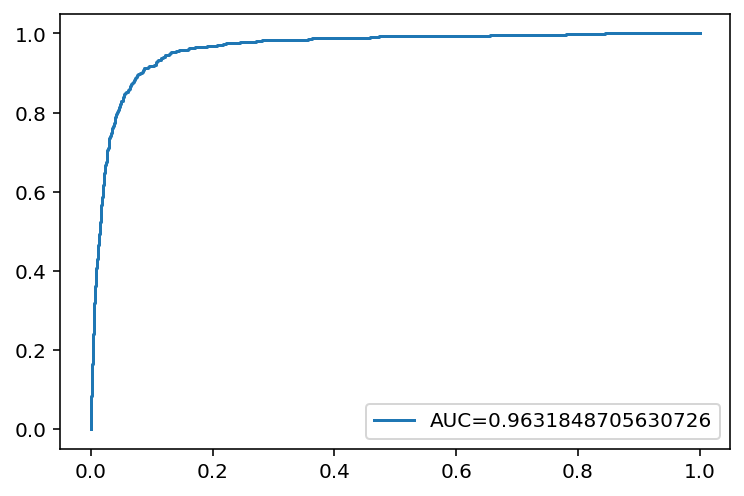

In [405]:
y_pred_proba = model_RFC_ARS.predict_proba(X_test_select)[:,1]
#print(y_pred_proba)

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

In [456]:
# Random Forest Gridsearch based on random search output

param_grid = {'bootstrap':[True],
              'n_estimators':[400,500],
              'min_samples_leaf':[7,8],
              'min_samples_split':[6,7],
                 'max_depth':[7,8],
             'max_features': [20,30],
             'criterion': ['entropy']}

#create a RF model
rfc = RandomForestClassifier()

#instantiate the grid search model
grid_search_rfc = GridSearchCV(estimator=rfc, param_grid = param_grid, cv=2, verbose=1)

#fit the grid search model to the data
grid_search_rfc.fit(X_train, y_train)
print(grid_search_rfc.best_params_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed: 22.3min finished


{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 30, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 500}


In [477]:
# Random Forest Final output

rfc_final = RandomForestClassifier( 
                            min_samples_leaf = 3,
                            min_samples_split = 2,
                            n_estimators=500, 
                            max_depth=8,
                            bootstrap = True,
                            criterion = 'gini',
                            max_features = 60)

model_RFC_final = rfc_final.fit(X_train, y_train)

y_pred_AGS_final = model_RFC_final.predict(X_test)

print(classification_report(y_test,y_pred_AGS_final))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     15073
           1       0.64      0.47      0.54       713

    accuracy                           0.96     15786
   macro avg       0.81      0.73      0.76     15786
weighted avg       0.96      0.96      0.96     15786



In [478]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_AGS_final,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14885,188
Actual group1,381,332


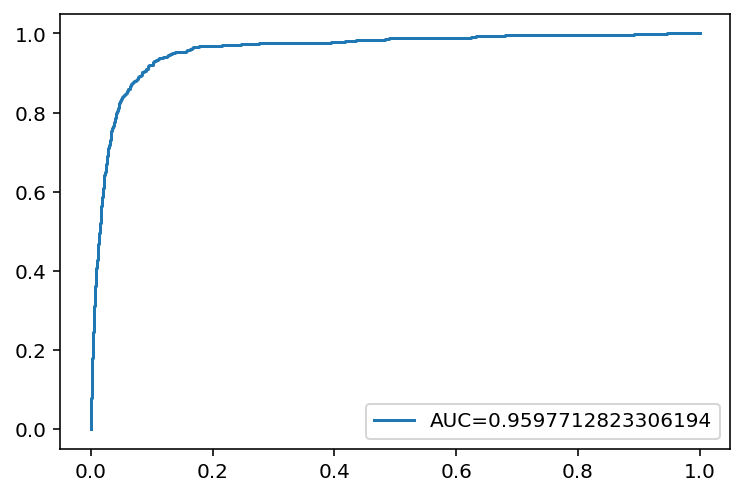

In [479]:
y_pred_proba = model_RFC_final.predict_proba(X_test)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### XG Boost

In [419]:
# XGBoost Randomized search - establish window to perform Grid Search

param_grid_XG = {'max_depth':[2, 3, 4,5,6],
                'learning_rate':[0.03, 0.05, 0.07,.1,.15],
                'n_estimators':[500,800,1000,1200],
                'gamma':[1, 3, 5],
                'min_child_weight':[1, 3, 5],
                'max_delta_step':[1, 3, 5],
                'reg_alpha':[1, 2, 3],
                'reg_lambda':[1, 2, 3],
                'scale_pos_weight':[8, 10, 12],
                'base_score':[0.1, 0.3, 0.5]}

# Create an XGBoost model

xg = XGBClassifier()

# Instantiate the grid search model
random_search_xg = RandomizedSearchCV(estimator=xg, param_distributions = param_grid_XG, n_iter=10, cv=5, verbose=1, random_state=0)

# Fit the grid search model to the data
random_search_xg.fit(X_train_select, y_train)
print(random_search_xg.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 81.4min finished


{'scale_pos_weight': 10, 'reg_lambda': 3, 'reg_alpha': 2, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 1, 'learning_rate': 0.15, 'gamma': 3, 'base_score': 0.3}


In [424]:
# Create an XG model to "store" random search best params
xg_boost_model = XGBClassifier(max_depth=6,
                learning_rate=0.15,
                n_estimators=500,
                gamma=3,
                min_child_weight=1,
                max_delta_step=1,
                reg_lambda=3,
                reg_alpha=2,
                scale_pos_weight=10,
                base_score=0.3)
                    
# Fit the model to the data
xg_boost_model.fit(X_train_select, y_train)

y_pred_xg = xg_boost_model.predict(X_test_select)

print(classification_report(y_test,y_pred_xg))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     15073
           1       0.52      0.69      0.60       713

    accuracy                           0.96     15786
   macro avg       0.75      0.83      0.79     15786
weighted avg       0.96      0.96      0.96     15786



In [425]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_xg,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14625,448
Actual group1,219,494


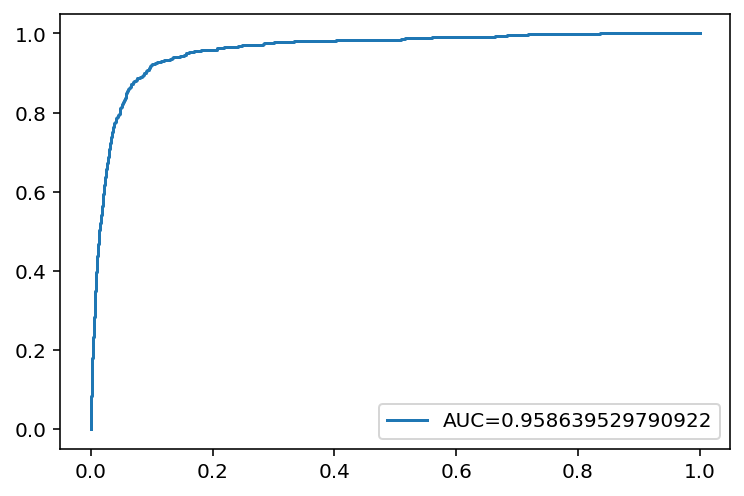

In [426]:
y_pred_proba = xg_boost_model.predict_proba(X_test_select)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

In [45]:
# XG Boost Gridsearch based on random search output

param_grid = {'max_depth':[6],
                'learning_rate':[0.15, 0.5],
                'n_estimators':[500],
                'gamma':[3],
                'min_child_weight':[1],
                'max_delta_step':[1, 3],
                'reg_alpha':[2, 4],
                'reg_lambda':[3],
                'scale_pos_weight':[1, 10],
                'base_score':[0.3, 1]}

#create a RF model
xg_final = XGBClassifier()

#instantiate the grid search model
grid_search_xg = GridSearchCV(estimator=xg_final, param_grid = param_grid, cv=2, verbose=1)

#fit the grid search model to the data
grid_search_xg.fit(X_train_select, y_train)
print(grid_search_xg.best_params_)


Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  4.7min finished


{'base_score': 0.3, 'gamma': 3, 'learning_rate': 0.15, 'max_delta_step': 3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 4, 'reg_lambda': 3, 'scale_pos_weight': 1}


In [740]:
# Final XG Model
xg_boost_model_final = XGBClassifier(max_depth=6,
                learning_rate=0.15,
                n_estimators=500,
                gamma=3,
                min_child_weight=1,
                max_delta_step=1,
                reg_lambda=3,
                reg_alpha=2,
                scale_pos_weight=10,
                base_score=0.3)
                    
# Fit the model to the data
xg_boost_model_final.fit(X_train_select, y_train)

y_pred_xg_fin = xg_boost_model_final.predict(X_test_select)

print(classification_report(y_test, y_pred_xg_fin))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     15073
           1       0.52      0.69      0.60       713

    accuracy                           0.96     15786
   macro avg       0.75      0.83      0.79     15786
weighted avg       0.96      0.96      0.96     15786



In [741]:
# Confusion matrix
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_xg_fin,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14625,448
Actual group1,219,494


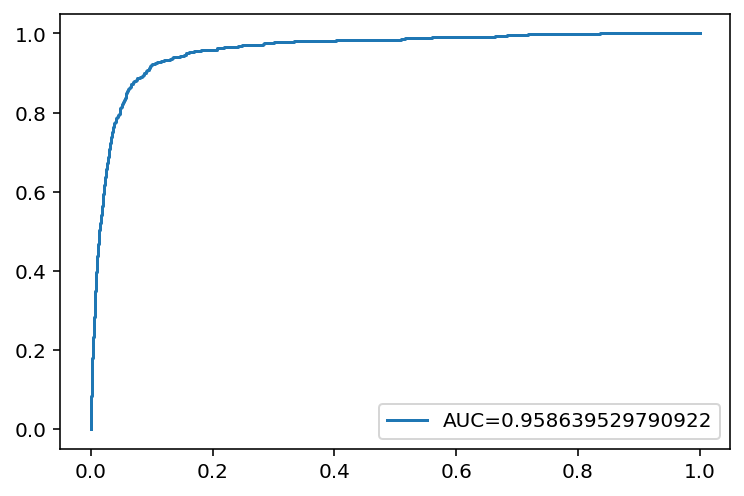

In [742]:
# AUC curve
y_pred_proba = xg_boost_model_final.predict_proba(X_test_select)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### Ada Boost

In [420]:
# ADABoost Randomized search - establish window to perform Grid Search

param_grid_ada = {'base_estimator':[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
                'learning_rate':[0.03, 0.05, 0.07,.1,.15],
                'n_estimators':[100,300,500,700,900,1000,1200],
                 'algorithm': ['SAMME', 'SAMME.R']}

# Create an ABABoost model
abc = AdaBoostClassifier()

# Instantiate the grid search model
random_search_ada = RandomizedSearchCV(estimator=xg, param_distributions = param_grid_ada, n_iter=10, cv=5, verbose=1, random_state=0)

# Fit the grid search model to the data
random_search_ada.fit(X_train_select, y_train)
print(random_search_ada.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 65.8min finished


{'n_estimators': 100, 'learning_rate': 0.07, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'algorithm': 'SAMME.R'}


In [421]:
# Create an ADABoost model to "store" random search best params
ada_boost_model = AdaBoostClassifier(learning_rate=0.07,
                                     base_estimator = DecisionTreeClassifier(max_depth=2),
                                     n_estimators=100,
                                    algorithm = 'SAMME.R')
                    
# Fit the model to the data
ada_boost_model.fit(X_train_select, y_train)

y_pred_ada = ada_boost_model.predict(X_test_select)

print(classification_report(y_test,y_pred_ada))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     15073
           1       0.66      0.44      0.53       713

    accuracy                           0.96     15786
   macro avg       0.82      0.72      0.76     15786
weighted avg       0.96      0.96      0.96     15786



In [422]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_ada,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14908,165
Actual group1,396,317


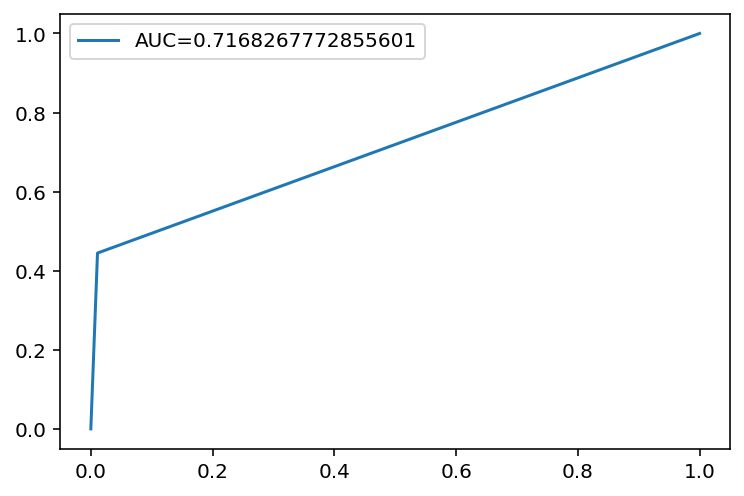

In [423]:
y_pred_proba = ada_boost_model.predict_proba(X_test_select)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_ada)
auc = metrics.roc_auc_score(y_test, y_pred_ada)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

In [49]:
# ADA Boost grid search based on random search
param_grid = {'base_estimator':[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
                'learning_rate':[0.03, 0.05, 0.07,.1,.15],
                'n_estimators':[100],
                 'algorithm': ['SAMME', 'SAMME.R']}

#create a RF model
ada_final = AdaBoostClassifier()

#instantiate the grid search model
grid_search_Ada = GridSearchCV(estimator=ada_final, param_grid = param_grid, cv=2, verbose=1)

#fit the grid search model to the data
grid_search_Ada.fit(X_train_select, y_train)
print(grid_search_Ada.best_params_)


Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.9min finished


{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'learning_rate': 0.07, 'n_estimators': 100}


In [53]:
# Final AdaBoost Model
ada_final = AdaBoostClassifier(learning_rate=0.07,
                                     base_estimator = DecisionTreeClassifier(max_depth=2),
                                     n_estimators=100,
                                    algorithm = 'SAMME.R')
                    
# Fit the model to the data
ada_final.fit(X_train_select, y_train)

y_pred_ada_fin = ada_final.predict(X_test_select)

print(classification_report(y_test,y_pred_ada_fin))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     15086
           1       0.68      0.47      0.56       700

    accuracy                           0.97     15786
   macro avg       0.83      0.73      0.77     15786
weighted avg       0.96      0.97      0.96     15786



In [54]:
# Confusion matrix
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_ada_fin,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14929,157
Actual group1,370,330


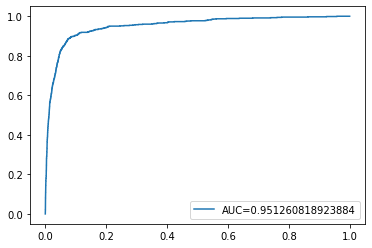

In [55]:
# AUC curve
y_pred_proba = ada_final.predict_proba(X_test_select)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### ANN

In [252]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

In [248]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from keras import regularizers
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

In [207]:
# Function to create model, required for KerasClassifier
def create_model(weight_constraint=0, epochs=10, batch_size=10, 
                 activation= 'linear', neurons= 5, optimizer='Adam', dropout_rate=0.0, init_mode='uniform'):
    model = Sequential()
    # input layer
    model.add(Dense(neurons, input_dim= 83, activation=activation, kernel_initializer=init_mode))
    # 1st layer
    model.add(Dense(neurons, activation=activation, kernel_initializer=init_mode))
    model.add(Dropout(dropout_rate))
    # 2nd layer
    model.add(Dense(neurons, activation=activation, kernel_initializer=init_mode))
    model.add(Dropout(dropout_rate))
    # output layer, sigmoid/logit for classification purposes, 1 node for the final output node
    model.add(Dense(1, activation='sigmoid'))
    # compile and create the ANN model, loss = binary crossentropy for classification purposes
    model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
clf = KerasClassifier(build_fn=create_model, verbose=0)

In [208]:
# define the grid search parameters
batch_size = [10, 20, 30, 50, 100]
epochs = [10, 50, 100]
weight_constraint = [1, 2, 3, 4, 5]

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['relu', 'tanh', 'sigmoid', 'linear']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
neurons = [1, 5, 10, 15, 20, 25, 50, 100, 128, 256, 400, 512]

param_grid = dict(batch_size=batch_size, epochs=epochs, weight_constraint=weight_constraint, optimizer=optimizer, \
                  init_mode=init_mode, activation=activation, dropout_rate=dropout_rate, neurons=neurons)

rs = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_jobs=-1, cv=3, verbose=1)
rs_result = rs.fit(X_train_select, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 32.7min finished


In [209]:
# summarize results
print("Best: %f using %s" % (rs_result.best_score_, rs_result.best_params_))
print()
means = rs_result.cv_results_['mean_test_score']
stds = rs_result.cv_results_['std_test_score']
params = rs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.964759 using {'weight_constraint': 5, 'optimizer': 'Adagrad', 'neurons': 100, 'init_mode': 'uniform', 'epochs': 50, 'dropout_rate': 0.9, 'batch_size': 30, 'activation': 'linear'}

0.954360 (0.001284) with: {'weight_constraint': 4, 'optimizer': 'SGD', 'neurons': 1, 'init_mode': 'zero', 'epochs': 10, 'dropout_rate': 0.8, 'batch_size': 10, 'activation': 'tanh'}
0.962315 (0.000892) with: {'weight_constraint': 3, 'optimizer': 'Adadelta', 'neurons': 5, 'init_mode': 'glorot_normal', 'epochs': 100, 'dropout_rate': 0.2, 'batch_size': 30, 'activation': 'sigmoid'}
0.960741 (0.001615) with: {'weight_constraint': 3, 'optimizer': 'Adagrad', 'neurons': 100, 'init_mode': 'he_normal', 'epochs': 100, 'dropout_rate': 0.6, 'batch_size': 10, 'activation': 'tanh'}
0.959763 (0.001276) with: {'weight_constraint': 1, 'optimizer': 'Adam', 'neurons': 400, 'init_mode': 'lecun_uniform', 'epochs': 10, 'dropout_rate': 0.3, 'batch_size': 10, 'activation': 'tanh'}
0.964759 (0.000894) with: {'weight_constraint'

In [213]:
'''final_model = create_model(weight_constraint=5, optimizer='Adagrad', neurons=100, init_mode='uniform', 
                         epochs=50, dropout_rate=0.9, batch_size=30, activation='linear')'''
rs_result.best_params_

{'weight_constraint': 5,
 'optimizer': 'Adagrad',
 'neurons': 100,
 'init_mode': 'uniform',
 'epochs': 50,
 'dropout_rate': 0.9,
 'batch_size': 30,
 'activation': 'linear'}

In [214]:
# Implement model with random search hyperparameters
f_activation = 'linear'
f_init_mode = 'uniform'
f_neurons = 100
f_dropout_rate = 0.9
f_optimizer = 'Adagrad'
f_epochs = 50

model = Sequential()
model.add(Dense(f_neurons, input_dim= 83, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dense(f_neurons, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dropout(f_dropout_rate))
model.add(Dense(f_neurons, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dropout(f_dropout_rate))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= f_optimizer, metrics=['accuracy'])

model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
ann = model.fit(x=X_train_select,y=y_train,verbose=0,epochs=f_epochs, validation_split=0.3)

<Figure size 576x432 with 0 Axes>

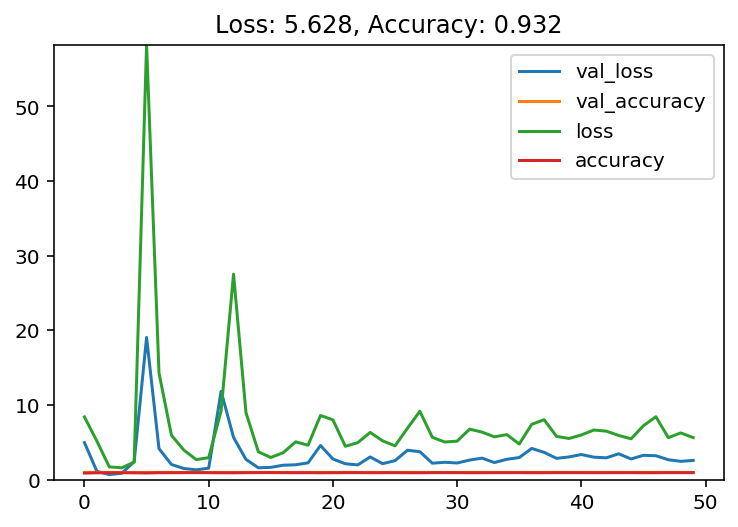

In [215]:
plot_loss_accuracy(ann)

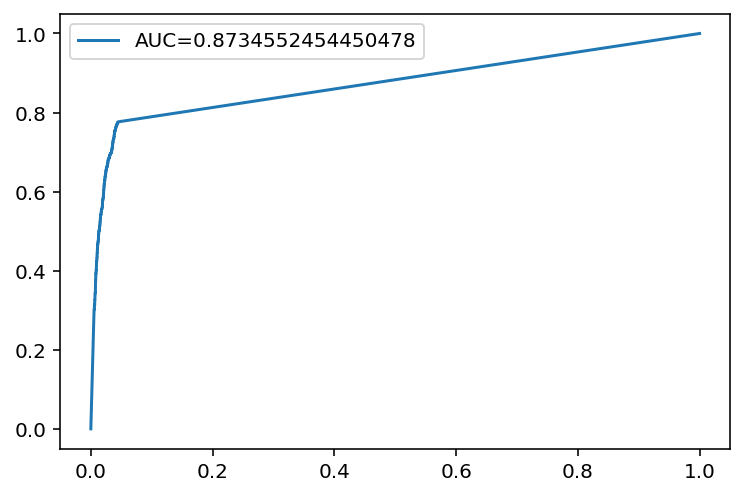

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     15021
           1       0.70      0.35      0.46       765

    accuracy                           0.96     15786
   macro avg       0.83      0.67      0.72     15786
weighted avg       0.95      0.96      0.95     15786

[[14909   112]
 [  501   264]]


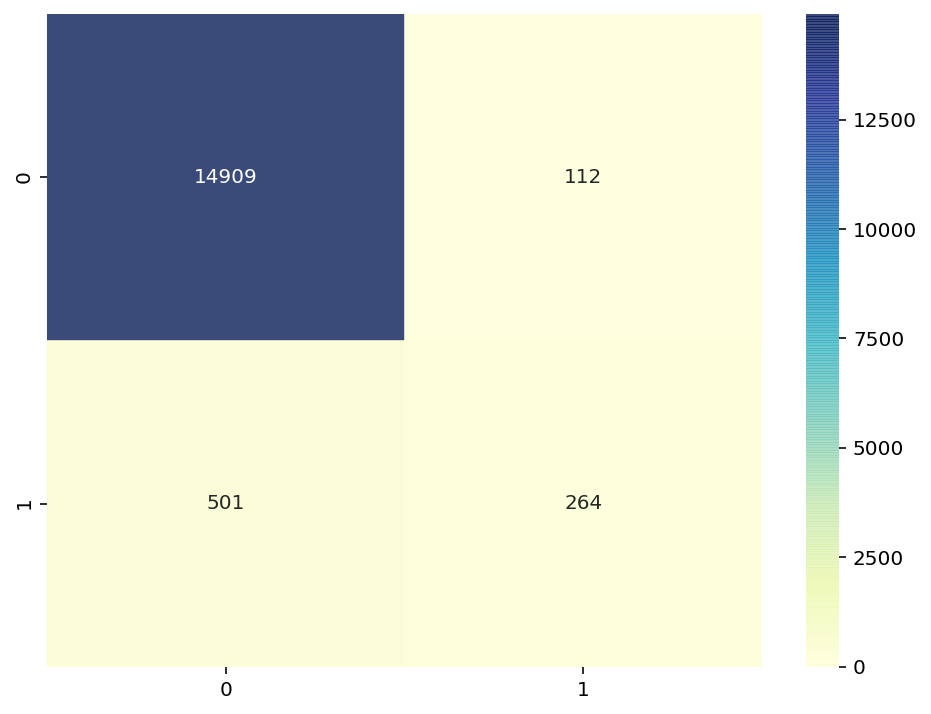

In [216]:
from sklearn import metrics

#AUC curve
y_pred_proba = model.predict(X_test_select).ravel()
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba) # 
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

# Get classification report
from sklearn.metrics import classification_report
y_pred_ann = model.predict_classes(X_test_select)
print(classification_report(y_test, y_pred_ann))

print(confusion_matrix(y_test,y_pred_ann))
plot_confusion_matrix(model,X_test_select,y_test)

## Model Initiation - W/O FICO score 

In [630]:
X_train_less_fico = X_train[['addr_state_CA', 'initial_list_status_w', 'sub_grade_E2',
       'verification_status_Verified', 'loan_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 
                             #'fico_range_low', 
                             'inq_last_6mths',
       'open_acc', 'total_acc', 
                             #'last_fico_range_high',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 
        'home_ownership_OWN', 'home_ownership_RENT',
       'addr_state_FL', 'addr_state_NY', 'addr_state_PA', 'addr_state_TX',
       'term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'sub_grade_C2', 'sub_grade_C4', 'sub_grade_D4',
       'verification_status_Source Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_other', 'funded_amnt', 'dti', 'delinq_2yrs',
       #'fico_range_high', 
                             'mths_since_last_delinq', 'pub_rec',
       'revol_bal', 'revol_util', 
                             #'last_fico_range_low',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'mo_sin_old_rev_tl_op', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies'
                         ]]

X_test_less_fico = X_test[['addr_state_CA', 'initial_list_status_w', 'sub_grade_E2',
       'verification_status_Verified', 'loan_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 
                           #'fico_range_low', 
                           'inq_last_6mths',
       'open_acc', 'total_acc', 
                           #'last_fico_range_high',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       'home_ownership_OWN', 'home_ownership_RENT',
       'addr_state_FL', 'addr_state_NY', 'addr_state_PA', 'addr_state_TX',
       'term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'sub_grade_C2', 'sub_grade_C4', 'sub_grade_D4',
       'verification_status_Source Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_other', 'funded_amnt', 'dti', 'delinq_2yrs',
       #'fico_range_high', 
                           'mths_since_last_delinq', 'pub_rec',
       'revol_bal', 'revol_util', 
                           #'last_fico_range_low',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'mo_sin_old_rev_tl_op', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies']]

#### XG Boost

In [713]:
# XGBoost model without FICO Score
xg_boost_model_final = XGBClassifier(max_depth=6,
                learning_rate=0.15,
                n_estimators=500,
                gamma=3,
                min_child_weight=1,
                max_delta_step=1,
                reg_lambda=3,
                reg_alpha=4,
                scale_pos_weight=1,
                base_score=0.3)
                    
# Fit the model to the data
xg_boost_model_final.fit(X_train_less_fico, y_train)

y_pred_xg_fin = xg_boost_model_final.predict(X_test_less_fico)

print(classification_report(y_test, y_pred_xg_fin))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     15073
           1       0.00      0.00      0.00       713

    accuracy                           0.95     15786
   macro avg       0.48      0.50      0.49     15786
weighted avg       0.91      0.95      0.93     15786



In [714]:
# Confusion matrix
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_xg_fin,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,15071,2
Actual group1,713,0


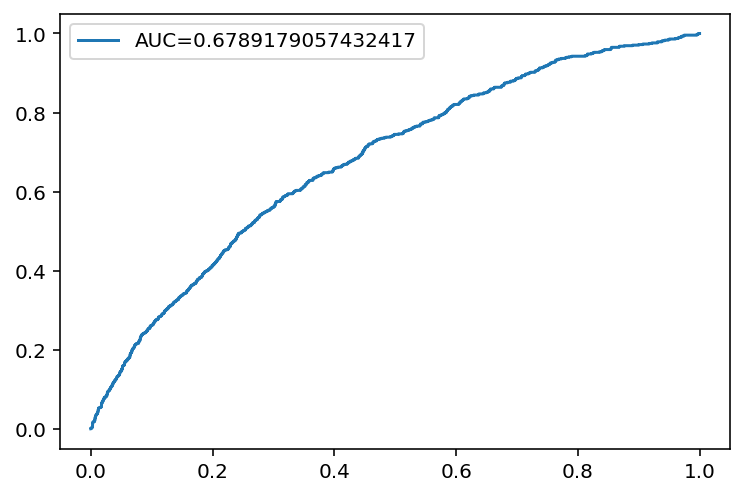

In [715]:
# AUC curve
y_pred_proba = xg_boost_model_final.predict_proba(X_test_less_fico)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### AdaBoost

In [716]:
# AdaBoost without FICO Score
ada_final = AdaBoostClassifier(learning_rate=0.07,
                                     base_estimator = DecisionTreeClassifier(max_depth=2),
                                     n_estimators=100,
                                    algorithm = 'SAMME.R')
                    
# Fit the model to the data
ada_final.fit(X_train_less_fico, y_train)

y_pred_ada_fin = ada_final.predict(X_test_less_fico)

print(classification_report(y_test,y_pred_ada_fin))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     15073
           1       0.00      0.00      0.00       713

    accuracy                           0.95     15786
   macro avg       0.48      0.50      0.49     15786
weighted avg       0.91      0.95      0.93     15786



In [717]:
# Confusion matrix
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_ada_fin,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,15073,0
Actual group1,713,0


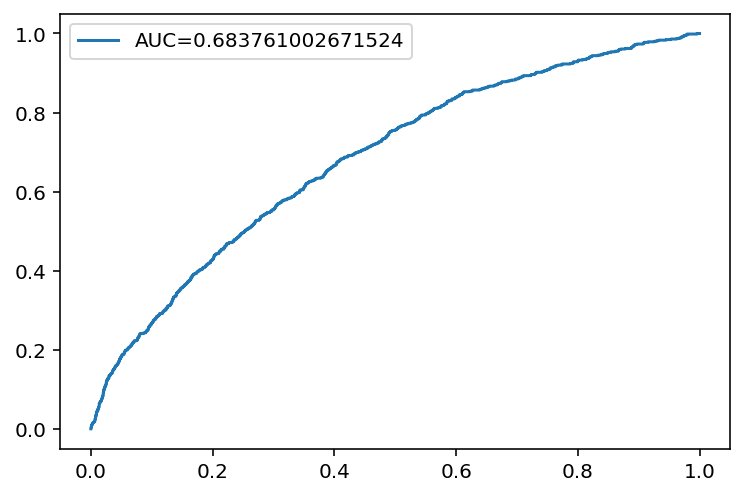

In [718]:
# AUC curve
y_pred_proba = ada_final.predict_proba(X_test_less_fico)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### Random Forest

In [719]:
# Random Forest without FICO

rfc_final = RandomForestClassifier( 
                            min_samples_leaf = 3,
                            min_samples_split = 2,
                            n_estimators=500, 
                            max_depth=8,
                            bootstrap = True,
                            criterion = 'gini',
                            max_features = 60)

model_RFC_final = rfc_final.fit(X_train_less_fico, y_train)

y_pred_AGS_final = model_RFC_final.predict(X_test_less_fico)

print(classification_report(y_test,y_pred_AGS_final))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     15073
           1       0.00      0.00      0.00       713

    accuracy                           0.95     15786
   macro avg       0.48      0.50      0.49     15786
weighted avg       0.91      0.95      0.93     15786



In [720]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_AGS_final,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,15073,0
Actual group1,713,0


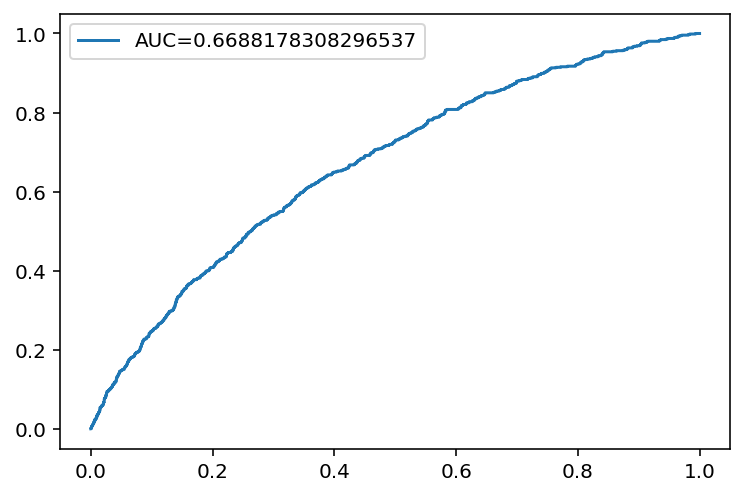

In [721]:
y_pred_proba = model_RFC_final.predict_proba(X_test_less_fico)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

### ANN

In [ ]:
# Implement model with random search hyperparameters
f_activation = 'linear'
f_init_mode = 'uniform'
f_neurons = 100
f_dropout_rate = 0.9
f_optimizer = 'Adagrad'
f_epochs = 50

model = Sequential()
model.add(Dense(f_neurons, input_dim= 79, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dense(f_neurons, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dropout(f_dropout_rate))
model.add(Dense(f_neurons, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dropout(f_dropout_rate))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= f_optimizer, metrics=['accuracy'])

model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
ann = model.fit(x=X_train_less_fico,y=y_train,verbose=0,epochs=f_epochs, validation_split=0.3)

In [ ]:
plot_loss_accuracy(ann)
from sklearn import metrics

#AUC curve
y_pred_proba = model.predict(X_test_less_fico).ravel()
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba) # 
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

# Get classification report
from sklearn.metrics import classification_report
y_pred_ann = model.predict_classes(X_test_less_fico)
print(classification_report(y_test, y_pred_ann))

print(confusion_matrix(y_test,y_pred_ann))
plot_confusion_matrix(model,X_test_less_fico,y_test)

## Model Initiation - W/O Lending Club Grade 

In [634]:
X_train_less_grade = X_train[['addr_state_CA', 'initial_list_status_w', 
                             #'sub_grade_E2',
       'verification_status_Verified', 'loan_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'total_acc', 'last_fico_range_high',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 
        'home_ownership_OWN', 'home_ownership_RENT',
       'addr_state_FL', 'addr_state_NY', 'addr_state_PA', 'addr_state_TX',
       'term_ 60 months', 
                             #'grade_B', 'grade_C', 'grade_D', 'grade_E',
       #'grade_F', 'sub_grade_C2', 'sub_grade_C4', 'sub_grade_D4',
       'verification_status_Source Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_other', 'funded_amnt', 'dti', 'delinq_2yrs',
       'fico_range_high', 'mths_since_last_delinq', 'pub_rec',
       'revol_bal', 'revol_util', 'last_fico_range_low',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'mo_sin_old_rev_tl_op', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies'
                         ]]

X_test_less_grade = X_test[['addr_state_CA', 'initial_list_status_w', 
                             #'sub_grade_E2',
       'verification_status_Verified', 'loan_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'total_acc', 'last_fico_range_high',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 
        'home_ownership_OWN', 'home_ownership_RENT',
       'addr_state_FL', 'addr_state_NY', 'addr_state_PA', 'addr_state_TX',
       'term_ 60 months', 
                             #'grade_B', 'grade_C', 'grade_D', 'grade_E',
       #'grade_F', 'sub_grade_C2', 'sub_grade_C4', 'sub_grade_D4',
       'verification_status_Source Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_other', 'funded_amnt', 'dti', 'delinq_2yrs',
       'fico_range_high', 'mths_since_last_delinq', 'pub_rec',
       'revol_bal', 'revol_util', 'last_fico_range_low',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'mo_sin_old_rev_tl_op', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies']]

#### XG Boost

In [635]:
# XGBoost without LC Grade
xg_boost_model_final = XGBClassifier(max_depth=6,
                learning_rate=0.15,
                n_estimators=500,
                gamma=3,
                min_child_weight=1,
                max_delta_step=1,
                reg_lambda=3,
                reg_alpha=4,
                scale_pos_weight=1,
                base_score=0.3)
                    
# Fit the model to the data
xg_boost_model_final.fit(X_train_less_grade, y_train)

y_pred_xg_fin = xg_boost_model_final.predict(X_test_less_grade)

print(classification_report(y_test, y_pred_xg_fin))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     15073
           1       0.63      0.50      0.56       713

    accuracy                           0.96     15786
   macro avg       0.80      0.74      0.77     15786
weighted avg       0.96      0.96      0.96     15786



In [636]:
# Confusion matrix
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_xg_fin,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14859,214
Actual group1,355,358


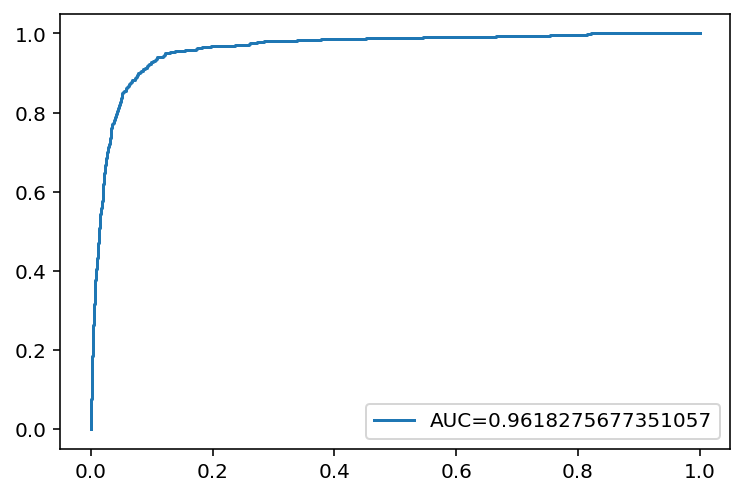

In [637]:
# AUC curve
y_pred_proba = xg_boost_model_final.predict_proba(X_test_less_grade)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### AdaBoost

In [707]:
# ADABoost model without LC Grade
ada_final = AdaBoostClassifier(learning_rate=0.07,
                                     base_estimator = DecisionTreeClassifier(max_depth=2),
                                     n_estimators=100,
                                    algorithm = 'SAMME.R')
                    
# Fit the model to the data
ada_final.fit(X_train_less_grade, y_train)

y_pred_ada_fin = ada_final.predict(X_test_less_grade)

print(classification_report(y_test,y_pred_ada_fin))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     15073
           1       0.66      0.43      0.52       713

    accuracy                           0.96     15786
   macro avg       0.82      0.71      0.75     15786
weighted avg       0.96      0.96      0.96     15786



In [708]:
# Confusion matrix
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_ada_fin,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14911,162
Actual group1,403,310


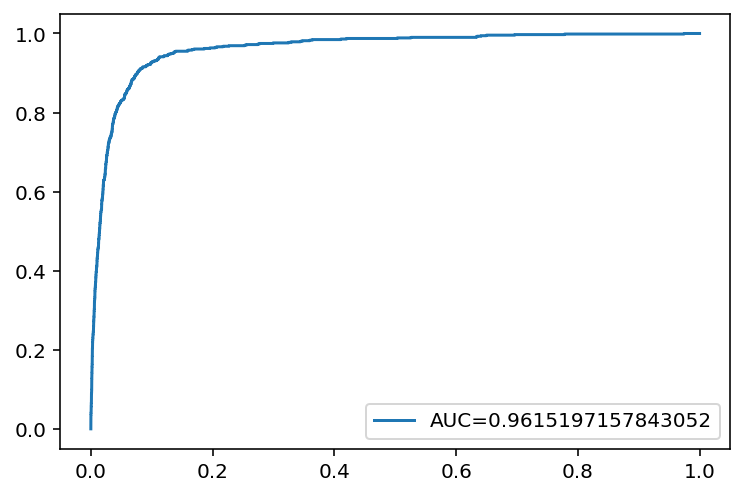

In [709]:
# AUC curve
y_pred_proba = ada_final.predict_proba(X_test_less_grade)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### Random Forest

In [710]:
# Random Forest without LC Grade

rfc_final = RandomForestClassifier( 
                            min_samples_leaf = 3,
                            min_samples_split = 2,
                            n_estimators=500, 
                            max_depth=8,
                            bootstrap = True,
                            criterion = 'gini',
                            max_features = 60)

model_RFC_final = rfc_final.fit(X_train_less_grade, y_train)

y_pred_AGS_final = model_RFC_final.predict(X_test_less_grade)

print(classification_report(y_test,y_pred_AGS_final))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     15073
           1       0.65      0.48      0.55       713

    accuracy                           0.96     15786
   macro avg       0.81      0.73      0.77     15786
weighted avg       0.96      0.96      0.96     15786



In [711]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_AGS_final,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14888,185
Actual group1,372,341


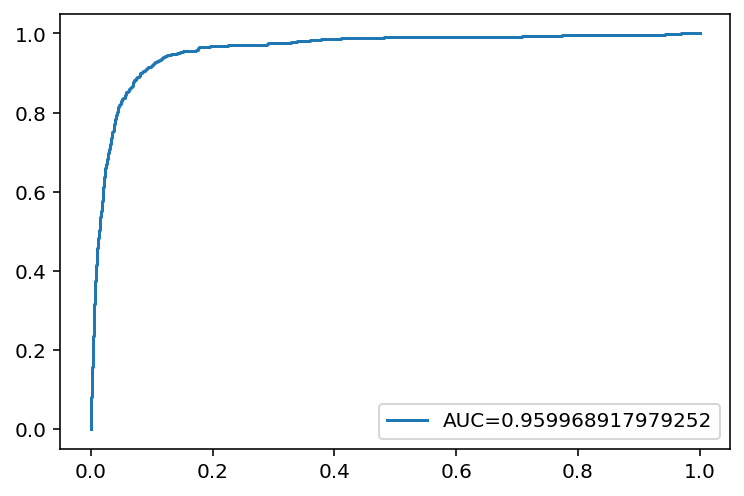

In [712]:
y_pred_proba = model_RFC_final.predict_proba(X_test_less_grade)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

### ANN

In [ ]:
# Implement model with random search hyperparameters
f_activation = 'linear'
f_init_mode = 'uniform'
f_neurons = 100
f_dropout_rate = 0.9
f_optimizer = 'Adagrad'
f_epochs = 50

model = Sequential()
model.add(Dense(f_neurons, input_dim= 74, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dense(f_neurons, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dropout(f_dropout_rate))
model.add(Dense(f_neurons, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dropout(f_dropout_rate))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= f_optimizer, metrics=['accuracy'])

model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
ann = model.fit(x=X_train_less_grade,y=y_train,verbose=0,epochs=f_epochs, validation_split=0.3)

In [ ]:
plot_loss_accuracy(ann)
from sklearn import metrics

#AUC curve
y_pred_proba = model.predict(X_test_less_grade).ravel()
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba) # 
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

# Get classification report
from sklearn.metrics import classification_report
y_pred_ann = model.predict_classes(X_test_less_grade)
print(classification_report(y_test, y_pred_ann))

print(confusion_matrix(y_test,y_pred_ann))
plot_confusion_matrix(model,X_test_less_grade,y_test)

## Model without Credit Score or Grade

In [667]:
print(X_train.columns[60:110])

Index(['addr_state_WV', 'addr_state_WY', 'initial_list_status_w',
       'term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house'],
      dtype='object')


In [673]:
X_train_with_out = X_train.copy()
X_test_with_out = X_test.copy()

fico_grade = ['fico_range_high','fico_range_low', 'last_fico_range_high', 'last_fico_range_low',
             'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']

for i in fico_grade:
    X_train_with_out.drop(i, axis=1, inplace=True)
    X_test_with_out.drop(i, axis=1, inplace=True)

#### A. XGBoost with RFECV

In [674]:
# removing '[' or ']' or < in any feature names to avoid below error
# ValueError: feature_names may not contain [, ] or <

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_with_out.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_with_out.columns.values]

In [670]:
xgb = XGBClassifier()
xgb.fit(X_train_with_out, y_train)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train_with_out.columns)
imp = imp.sort_values(['Importance'], ascending = False)

print(imp)

                                     Importance
funded_amnt_inv                            0.04
initial_list_status_w                      0.04
tot_coll_amt                               0.02
pub_rec                                    0.02
emp_length_4 years                         0.02
home_ownership_RENT                        0.02
acc_open_past_24mths                       0.02
verification_status_Verified               0.02
loan_amnt                                  0.02
delinq_2yrs                                0.02
mo_sin_old_rev_tl_op                       0.02
total_bc_limit                             0.02
mo_sin_rcnt_tl                             0.02
term_ 60 months                            0.02
installment                                0.02
revol_bal                                  0.02
pct_tl_nvr_dlq                             0.02
num_rev_tl_bal_gt_0                        0.02
annual_inc                                 0.02
total_acc                               

In [675]:
from sklearn.metrics import make_scorer 
from sklearn.feature_selection import RFECV

# https://www.kaggle.com/liyenhsu/feature-selection-and-ensemble-of-5-models

# instantiate XG estimator and fit to data
estimator = XGBClassifier()
selector = RFECV(estimator, cv = 3, n_jobs = -1, step = 5, min_features_to_select = 10)
selector = selector.fit(X_train_with_out, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept_end_xg = X_train_with_out.columns.values[selector.support_] 

The number of selected features is: 10


In [676]:
features_kept_end_xg

array(['home_ownership_RENT', 'initial_list_status_w', 'term_ 60 months',
       'verification_status_Verified', 'purpose_medical', 'loan_amnt',
       'funded_amnt_inv', 'installment', 'pub_rec', 'tot_coll_amt'],
      dtype=object)

#### A. RF with RFECV

In [677]:
# removing '[' or ']' or < in any feature names to avoid below error
# ValueError: feature_names may not contain [, ] or <

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_with_out.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_with_out.columns.values]

In [678]:
rfc = RandomForestClassifier()
rfc.fit(X_train_with_out, y_train)
imp = pd.DataFrame(rfc.feature_importances_ ,columns = ['Importance'],index = X_train_with_out.columns)
imp = imp.sort_values(['Importance'], ascending = False)

print(imp)

                                     Importance
mo_sin_old_rev_tl_op                       0.03
installment                                0.03
bc_open_to_buy                             0.03
revol_bal                                  0.03
avg_cur_bal                                0.03
tot_hi_cred_lim                            0.03
total_bal_ex_mort                          0.03
total_rev_hi_lim                           0.03
tot_cur_bal                                0.02
annual_inc                                 0.02
total_bc_limit                             0.02
mths_since_recent_revol_delinq             0.02
bc_util                                    0.02
mths_since_last_major_derog                0.02
mths_since_last_delinq                     0.02
total_il_high_credit_limit                 0.02
funded_amnt_inv                            0.02
mths_since_recent_bc                       0.02
total_acc                                  0.02
dti                                     

In [679]:
from sklearn.metrics import make_scorer 
from sklearn.feature_selection import RFECV

# https://www.kaggle.com/liyenhsu/feature-selection-and-ensemble-of-5-models

# instantiate XG estimator and fit to data
estimator = RandomForestClassifier()
selector = RFECV(estimator, cv = 3, n_jobs = -1, step = 5, min_features_to_select = 10)
selector = selector.fit(X_train_with_out, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept_end_rf = X_train_with_out.columns.values[selector.support_] 

The number of selected features is: 15


In [680]:
features_kept_end_rf

array(['funded_amnt_inv', 'installment', 'annual_inc', 'revol_bal',
       'total_acc', 'tot_cur_bal', 'total_rev_hi_lim', 'avg_cur_bal',
       'bc_open_to_buy', 'mo_sin_old_rev_tl_op', 'mths_since_recent_bc',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'], dtype=object)

In [681]:
total_features_end = []

for i in features_kept_end_xg:
    total_features_end.append(i)
    
for i in features_kept_end_rf:
    total_features_end.append(i)

pd.Series(total_features_end).unique()

array(['home_ownership_RENT', 'initial_list_status_w', 'term_ 60 months',
       'verification_status_Verified', 'purpose_medical', 'loan_amnt',
       'funded_amnt_inv', 'installment', 'pub_rec', 'tot_coll_amt',
       'annual_inc', 'revol_bal', 'total_acc', 'tot_cur_bal',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy',
       'mo_sin_old_rev_tl_op', 'mths_since_recent_bc', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'], dtype=object)

In [649]:
X_train_fin = X_train[['home_ownership_RENT', 'initial_list_status_w', 'term_ 60 months',
       'verification_status_Verified', 'purpose_medical', 'loan_amnt',
       'funded_amnt_inv', 'installment', 'pub_rec', 'tot_coll_amt',
       'annual_inc', 'revol_bal', 'total_acc', 'tot_cur_bal',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy',
       'mo_sin_old_rev_tl_op', 'mths_since_recent_bc', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit']]

X_test_fin = X_test[['home_ownership_RENT', 'initial_list_status_w', 'term_ 60 months',
       'verification_status_Verified', 'purpose_medical', 'loan_amnt',
       'funded_amnt_inv', 'installment', 'pub_rec', 'tot_coll_amt',
       'annual_inc', 'revol_bal', 'total_acc', 'tot_cur_bal',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy',
       'mo_sin_old_rev_tl_op', 'mths_since_recent_bc', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit']]

#### XG Boost

In [688]:
# Best Alternative XGBoost model

param_grid_XG = {'max_depth':[2, 3, 4,5,6],
                'learning_rate':[0.03, 0.05, 0.07,.1,.15],
                'n_estimators':[500,800,1000,1200],
                'gamma':[1, 3, 5],
                'min_child_weight':[1, 3, 5],
                'max_delta_step':[1, 3, 5],
                'reg_alpha':[1, 2, 3],
                'reg_lambda':[1, 2, 3],
                'scale_pos_weight':[8, 10, 12],
                'base_score':[0.1, 0.3, 0.5]}

# Create an XGBoost model

xg = XGBClassifier()

# Instantiate the grid search model
random_search_xg_wo = RandomizedSearchCV(estimator=xg, param_distributions = param_grid_XG, n_iter=5, cv=5, verbose=1, random_state=0)

# Fit the grid search model to the data
random_search_xg_wo.fit(X_train_fin, y_train)
print(random_search_xg_wo.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 15.7min finished


{'scale_pos_weight': 10, 'reg_lambda': 3, 'reg_alpha': 2, 'n_estimators': 800, 'min_child_weight': 3, 'max_depth': 6, 'max_delta_step': 5, 'learning_rate': 0.1, 'gamma': 3, 'base_score': 0.1}


In [696]:
# Create an XG model to "store" GridSearch best params
xg_boost_model_final = XGBClassifier(max_depth=2,
                learning_rate=0.1,
                n_estimators=800,
                gamma=3,
                min_child_weight=3,
                max_delta_step=5,
                reg_lambda=3,
                reg_alpha=2,
                scale_pos_weight=10,
                base_score=0.8)
                    
# Fit the model to the data
xg_boost_model_final.fit(X_train_fin, y_train)

y_pred_xg_fin = xg_boost_model_final.predict(X_test_fin)

print(classification_report(y_test, y_pred_xg_fin))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     15073
           1       0.11      0.19      0.14       713

    accuracy                           0.90     15786
   macro avg       0.54      0.56      0.54     15786
weighted avg       0.92      0.90      0.91     15786



In [697]:
# Confusion matrix
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_xg_fin,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,14008,1065
Actual group1,577,136


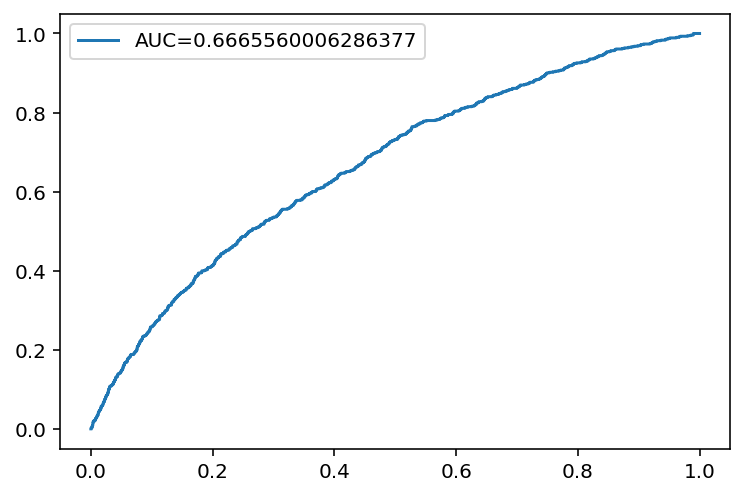

In [698]:
# AUC curve
y_pred_proba = xg_boost_model_final.predict_proba(X_test_fin)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### Random Forest

In [699]:
# Best alternative Random Forrest model

param_grid_rand = {'bootstrap':[True, False],
              'max_features':[5,10,15,20,30,40,50,60,70,80,90,100],
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
              'min_samples_split':[2,3,4,5,6,7,8,9,10],
              'n_estimators':[100,200,300,400,500,550,600,700,800,900],
                'max_depth':[2,3,4,5,6,7,8,9,10],
                'criterion': ['gini', 'entropy']}

# create a RF model
rfc = RandomForestClassifier()

# instantiate random grid search model
random_search_rfc_fin = RandomizedSearchCV(estimator=rfc, param_distributions = param_grid_rand, n_iter=10, cv=5, verbose=1, random_state=0)

# fit the grid search model to the data
random_search_rfc_fin.fit(X_train_fin, y_train)
print(random_search_rfc_fin.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 27.0min finished


{'n_estimators': 200, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 20, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}


In [700]:
# "storing" best results from random search as a basis for further grid searching

rfc = RandomForestClassifier(
                            min_samples_leaf = 7,
                            min_samples_split = 9,
                            n_estimators = 200,
                            max_depth = 3,
                           bootstrap = False,
                            max_features = 20,
                            criterion = 'entropy')

model_RFC_ARS = rfc.fit(X_train_fin, y_train)

model_RFC_pred = model_RFC_ARS.predict(X_test_fin)

print(classification_report(y_test,model_RFC_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     15073
           1       0.00      0.00      0.00       713

    accuracy                           0.95     15786
   macro avg       0.48      0.50      0.49     15786
weighted avg       0.91      0.95      0.93     15786



In [701]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, model_RFC_pred,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,15073,0
Actual group1,713,0


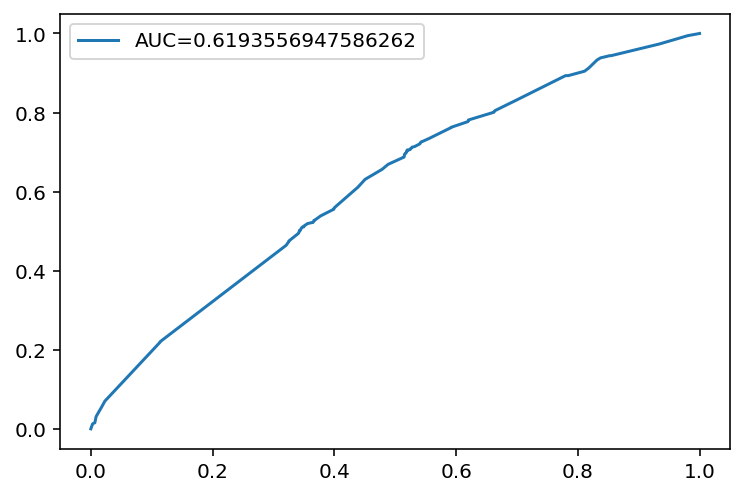

In [702]:
y_pred_proba = model_RFC_ARS.predict_proba(X_test_fin)[:,1]
#print(y_pred_proba)

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

#### Ada Boost

In [703]:
# Best alternative ADABoost model

param_grid_ada = {'base_estimator':[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
                'learning_rate':[0.03, 0.05, 0.07,.1,.15],
                'n_estimators':[100,300,500,700,900,1000,1200],
                 'algorithm': ['SAMME', 'SAMME.R']}

# Create an ABABoost model
abc = AdaBoostClassifier()

# Instantiate the grid search model
random_search_ada_fin = RandomizedSearchCV(estimator=xg, param_distributions = param_grid_ada, n_iter=10, cv=5, verbose=1, random_state=0)

# Fit the grid search model to the data
random_search_ada_fin.fit(X_train_fin, y_train)
print(random_search_ada_fin.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 28.4min finished


{'n_estimators': 100, 'learning_rate': 0.07, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'algorithm': 'SAMME.R'}


In [704]:
# Create an ADABoost model to "store" random search best params
ada_boost_model = AdaBoostClassifier(learning_rate=0.07,
                                     base_estimator = DecisionTreeClassifier(max_depth=2),
                                     n_estimators=100,
                                    algorithm = 'SAMME.R')
                    
# Fit the model to the data
ada_boost_model.fit(X_train_fin, y_train)

y_pred_ada = ada_boost_model.predict(X_test_fin)

print(classification_report(y_test,y_pred_ada))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     15073
           1       0.00      0.00      0.00       713

    accuracy                           0.95     15786
   macro avg       0.48      0.50      0.49     15786
weighted avg       0.91      0.95      0.93     15786



In [705]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred_ada,), columns=["Predicted group" + str(cat) for cat in [0,1]], index =[ "Actual group" + str(cat) for cat in [0,1]])
confusion_df

,Predicted group0,Predicted group1
Actual group0,15073,0
Actual group1,713,0


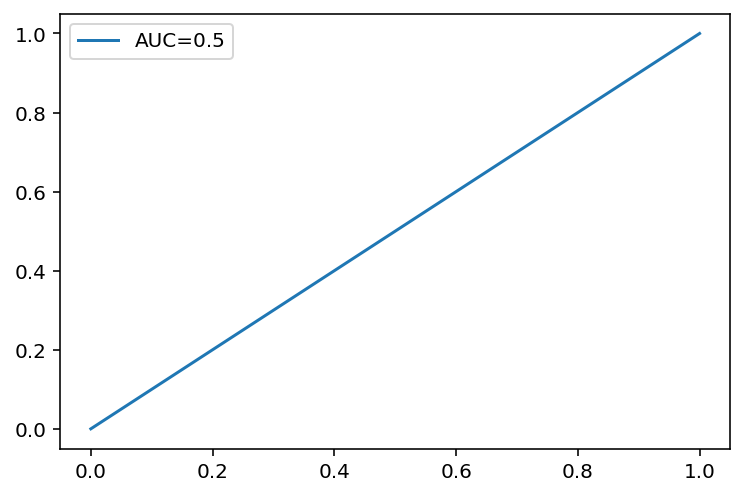

In [706]:
y_pred_proba = ada_boost_model.predict_proba(X_test_fin)[:,1]

fpr, tpr,t = metrics.roc_curve(y_test, y_pred_ada)
auc = metrics.roc_auc_score(y_test, y_pred_ada)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

### ANN

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(weight_constraint=0, epochs=10, batch_size=10, input_dim=83,
                 activation= 'linear', neurons= 5, optimizer='Adam', dropout_rate=0.0, init_mode='uniform'):
    model = Sequential()
    # input layer
    model.add(Dense(neurons, input_dim=input_dim, activation=activation, kernel_initializer=init_mode))
    # 1st layer
    model.add(Dense(neurons, activation=activation, kernel_initializer=init_mode))
    model.add(Dropout(dropout_rate))
    # 2nd layer
    model.add(Dense(neurons, activation=activation, kernel_initializer=init_mode))
    model.add(Dropout(dropout_rate))
    # output layer, sigmoid/logit for classification purposes, 1 node for the final output node
    model.add(Dense(1, activation='sigmoid'))
    # compile and create the ANN model, loss = binary crossentropy for classification purposes
    model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
clf = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
# define the grid search parameters
batch_size = [10, 20, 30, 50, 100]
epochs = [10, 50, 100]
weight_constraint = [1, 2, 3, 4, 5]

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['relu', 'tanh', 'sigmoid', 'linear']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
neurons = [1, 5, 10, 15, 20, 25, 50, 100, 128, 256, 400, 512]

param_grid = dict(batch_size=batch_size, epochs=epochs, weight_constraint=weight_constraint, optimizer=optimizer, \
                  init_mode=init_mode, activation=activation, dropout_rate=dropout_rate, neurons=neurons, \
                  input_dim=[23])

rs = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_jobs=-1, cv=3, verbose=1)
rs_result = rs.fit(X_train_fin, y_train)

In [ ]:
# summarize results
print("Best: %f using %s" % (rs_result.best_score_, rs_result.best_params_))
print()
means = rs_result.cv_results_['mean_test_score']
stds = rs_result.cv_results_['std_test_score']
params = rs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Implement model with random search hyperparameters
f_activation = 'tanh'
f_init_mode = 'zero'
f_neurons = 1
f_dropout_rate = 0.8
f_optimizer = 'SGD'
f_epochs = 10
weight_constraint = 4
batch_size = 10

model = Sequential()
model.add(Dense(f_neurons, input_dim= 23, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dense(f_neurons, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dropout(f_dropout_rate))
model.add(Dense(f_neurons, activation=f_activation, kernel_initializer=f_init_mode))
model.add(Dropout(f_dropout_rate))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= f_optimizer, metrics=['accuracy'])

model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
ann = model.fit(x=X_train_fin,y=y_train,verbose=0,epochs=f_epochs, batch_size = batch_size, validation_split=0.3)

In [ ]:
plot_loss_accuracy(ann)
from sklearn import metrics

#AUC curve
y_pred_proba = model.predict(X_test_fin).ravel()
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba) # 
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

# Get classification report
from sklearn.metrics import classification_report
y_pred_ann = model.predict_classes(X_test_fin)
print(classification_report(y_test, y_pred_ann))

print(confusion_matrix(y_test,y_pred_ann))
plot_confusion_matrix(model,X_test_fin,y_test)

### Slide 6 Graphics

In [735]:
models = ['ANN', 'XGBoost', 'Random Forest', 'ADABoost']
categories = ['Pre Variable Removal', 'W/O Fico Score', 'W/O LC Grade', 'Best Alternative Result']
data = [[.35, .69, .47, .47], [0, 0, 0, 0], [.18, .50, .48, .43], [0, .19, 0, 0]]

In [736]:
graph_data = pd.DataFrame(data=data, index=categories, columns=models)
graph_data

,ANN,XGBoost,Random Forest,ADABoost
Pre Variable Removal,0.35,0.69,0.47,0.47
W/O Fico Score,0.00,0.00,0.00,0.00
W/O LC Grade,0.18,0.50,0.48,0.43
Best Alternative Result,0.00,0.19,0.00,0.00


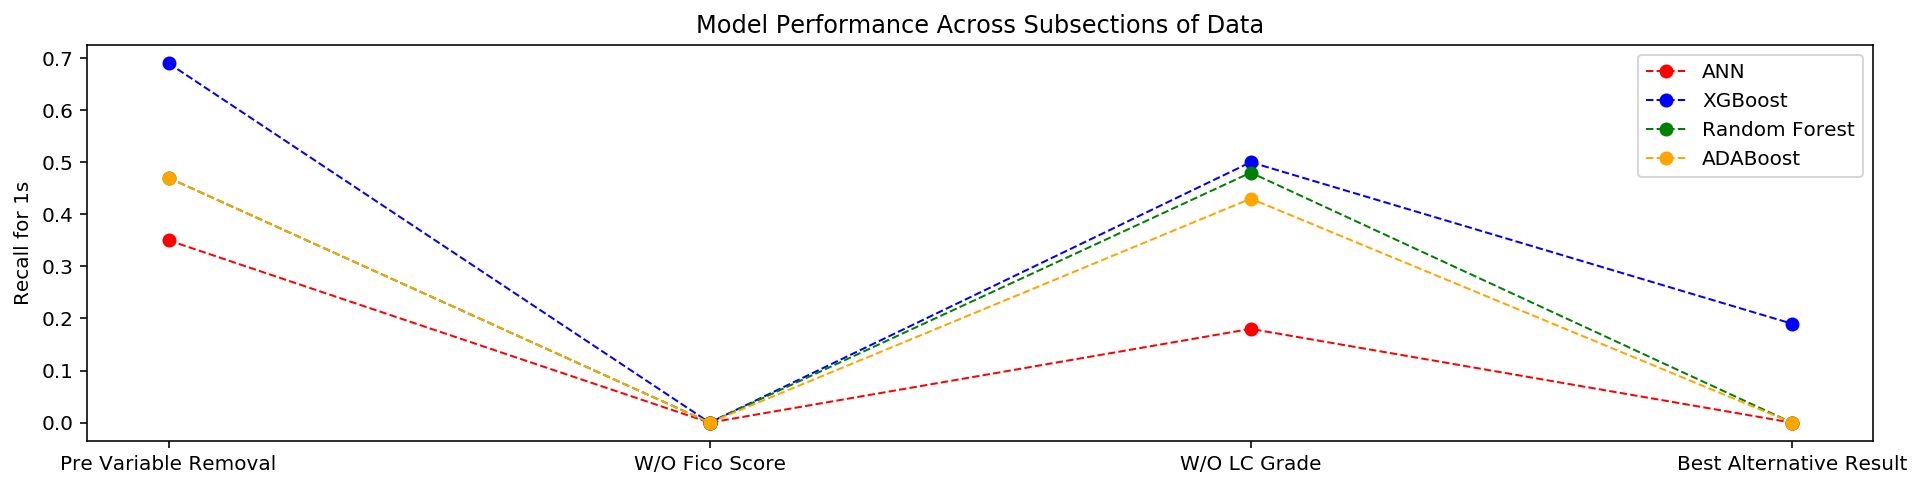

In [737]:
# Create figure, with a size of 16 by 8 inches
fig=plt.figure(figsize = (16,8))

# Add subplot
ax1 = fig.add_subplot(2,1,1)

# Plot the data
ax1.plot(graph_data['ANN'], color='red', linestyle='--', linewidth=1, marker='o', label='ANN')
ax1.plot(graph_data['XGBoost'], color='blue', linestyle='--', linewidth=1, marker='o', label='XGBoost')
ax1.plot(graph_data['Random Forest'], color='green', linestyle='--', linewidth=1, marker='o', label='Random Forest')
ax1.plot(graph_data['ADABoost'], color='orange', linestyle='--', linewidth=1, marker='o', label='ADABoost')

# Add title to the plot
ax1.set_title("Model Performance Across Subsections of Data")

# Add labels to the axes
ax1.set_ylabel('Recall for 1s')

# Add legend to the graph, and let matplotlib place it at the best location
ax1.legend(loc='best');